In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
data_path = "/content/Data.csv"
stock_path = "/content/StockPrice.csv"

data_df = pd.read_csv(data_path)
stock_df = pd.read_csv(stock_path)

print("Data columns:", data_df.columns.tolist())
print("Stock columns:", stock_df.columns.tolist())

data_df.head(), stock_df.head()

Data columns: ['Date', 'Data']
Stock columns: ['Date', 'Price']


(         Date   Data
 0  2025-03-26  2.369
 1  2025-03-25  2.365
 2  2025-03-24  2.367
 3  2025-03-21  2.386
 4  2025-03-20  2.387,
          Date    Price
 0  2025-03-26  5759.50
 1  2025-03-25  5826.50
 2  2025-03-24  5815.50
 3  2025-03-21  5718.25
 4  2025-03-20  5712.75)

In [3]:
# Expected columns based on given files:
# Data.csv:  Date, Data
# StockPrice.csv: Date, Price

df = pd.merge(data_df, stock_df, on="Date", how="inner")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Rename for clarity
df = df.rename(columns={"Data": "D", "Price": "P"})

df.head(), df.tail(), df.shape

(        Date      D        P
 0 2010-01-04  0.700  1178.00
 1 2010-01-05  0.699  1181.50
 2 2010-01-06  0.694  1182.25
 3 2010-01-07  0.692  1186.75
 4 2010-01-08  0.691  1190.75,
            Date      D        P
 3797 2025-03-20  2.387  5712.75
 3798 2025-03-21  2.386  5718.25
 3799 2025-03-24  2.367  5815.50
 3800 2025-03-25  2.365  5826.50
 3801 2025-03-26  2.369  5759.50,
 (3802, 3))

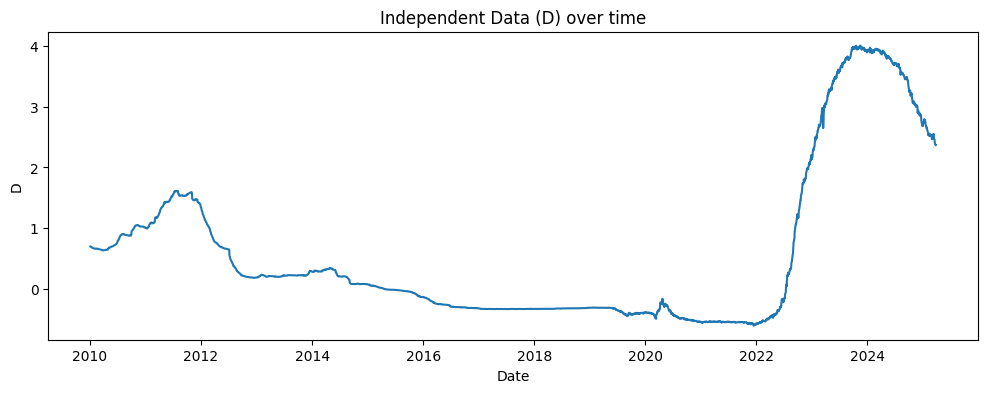

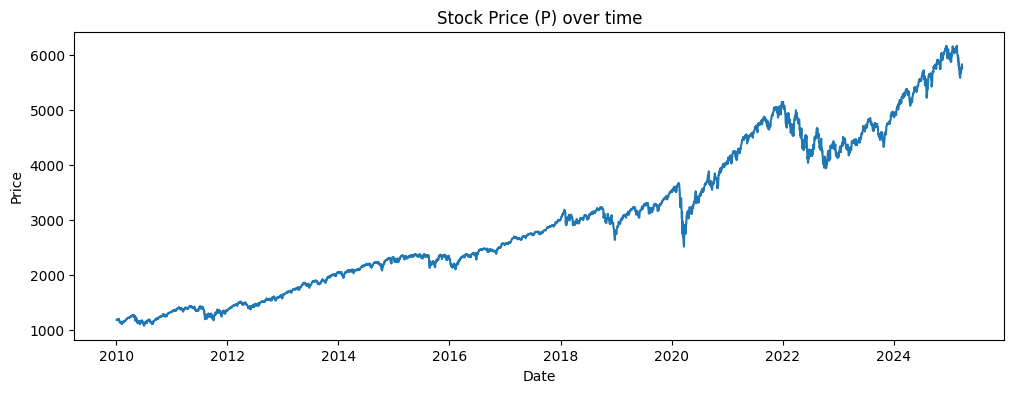

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["D"])
plt.title("Independent Data (D) over time")
plt.xlabel("Date"); plt.ylabel("D")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["P"])
plt.title("Stock Price (P) over time")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

In [5]:
# Base changes
df["d_ret"] = df["D"].pct_change()          # r^D_t
df["p_ret"] = df["P"].pct_change()          # r^P_t  (target)

# Surprise + Z-score normalization
W = 20  # rolling window
mu = df["d_ret"].rolling(W).mean()
sig = df["d_ret"].rolling(W).std(ddof=0)

df["d_z"] = (df["d_ret"] - mu) / sig        # Z_t

# Momentum (MACD-like)
df["d_ema_fast"] = df["d_ret"].ewm(span=10, adjust=False).mean()
df["d_ema_slow"] = df["d_ret"].ewm(span=30, adjust=False).mean()
df["d_mom"] = df["d_ema_fast"] - df["d_ema_slow"]

# Acceleration (2nd difference on returns)
df["d_acc"] = df["d_ret"] - df["d_ret"].shift(1)

# Strength indicators
df["abs_z"] = df["d_z"].abs()
df["d_sign"] = np.sign(df["d_ret"])

df[["Date","D","P","d_ret","d_z","d_mom","d_acc"]].tail(10)

,Date,D,P,d_ret,d_z,d_mom,d_acc
3792,2025-03-13,2.501,5577.75,-0.010289,-1.341005,-0.000233,-0.000105
3793,2025-03-14,2.478,5690.25,-0.009196,-1.076766,-0.001120,0.001093
3794,2025-03-17,2.456,5730.50,-0.008878,-1.111017,-0.001748,0.000318
3795,2025-03-18,2.426,5668.25,-0.012215,-1.443001,-0.002600,-0.003337
3796,2025-03-19,2.411,5728.75,-0.006183,-0.538483,-0.002514,0.006032
3797,2025-03-20,2.387,5712.75,-0.009954,-0.970621,-0.002861,-0.003771
3798,2025-03-21,2.386,5718.25,-0.000419,0.319403,-0.001975,0.009535
3799,2025-03-24,2.367,5815.50,-0.007963,-0.666243,-0.002158,-0.007544
3800,2025-03-25,2.365,5826.50,-0.000845,0.350161,-0.001438,0.007118
3801,2025-03-26,2.369,5759.50,0.001691,0.628209,-0.000572,0.002536


In [6]:
# Used ONLY previous day signals as features (strict)
feature_cols_raw = ["d_ret", "d_z", "d_mom", "d_acc", "abs_z", "d_sign"]
for c in feature_cols_raw:
    df[c + "_l1"] = df[c].shift(1)

X_cols = [c + "_l1" for c in feature_cols_raw]
y_col = "p_ret"

model_df = df.dropna().reset_index(drop=True)

X = model_df[X_cols]
y = model_df[y_col]

print("Rows for modeling:", len(model_df))
print("Features:", X_cols)

Rows for modeling: 3762
Features: ['d_ret_l1', 'd_z_l1', 'd_mom_l1', 'd_acc_l1', 'abs_z_l1', 'd_sign_l1']


In [7]:
split = int(len(model_df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(X_train.shape, X_test.shape)

(3009, 6) (753, 6)


In [8]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
pred_ret_ridge = ridge.predict(X_test)

mse_ret = mean_squared_error(y_test, pred_ret_ridge)
r2_ret = r2_score(y_test, pred_ret_ridge)

print("Ridge | Return MSE:", mse_ret)
print("Ridge | Return R² :", r2_ret)

Ridge | Return MSE: 0.00014448044367255928
Ridge | Return R² : -0.41641941228660717


In [9]:
hgb = HistGradientBoostingRegressor(random_state=42)

# Light tuning (fast & safe)
param_dist = {
    "learning_rate": [0.01, 0.03, 0.05, 0.08],
    "max_depth": [2, 3, 4, 5],
    "max_iter": [200, 400, 800],
    "min_samples_leaf": [10, 20, 50]
}

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_hgb = search.best_estimator_

print("Best HGB params:", search.best_params_)

pred_ret_hgb = best_hgb.predict(X_test)

mse_ret_hgb = mean_squared_error(y_test, pred_ret_hgb)
r2_ret_hgb = r2_score(y_test, pred_ret_hgb)

print("HGB | Return MSE:", mse_ret_hgb)
print("HGB | Return R² :", r2_ret_hgb)

Best HGB params: {'min_samples_leaf': 20, 'max_iter': 200, 'max_depth': 4, 'learning_rate': 0.01}
HGB | Return MSE: 0.00010212384609577043
HGB | Return R² : -0.0011749299112377987


In [10]:
# Align previous true price for the test period
P_true = model_df["P"].iloc[split:].to_numpy()
P_prev = model_df["P"].iloc[split-1:-1].to_numpy()

P_pred_ridge = P_prev * (1 + pred_ret_ridge)
P_pred_hgb   = P_prev * (1 + pred_ret_hgb)

mse_price_ridge = mean_squared_error(P_true, P_pred_ridge)
r2_price_ridge  = r2_score(P_true, P_pred_ridge)

mse_price_hgb = mean_squared_error(P_true, P_pred_hgb)
r2_price_hgb  = r2_score(P_true, P_pred_hgb)

print("Ridge | Price MSE:", mse_price_ridge, " | Price R²:", r2_price_ridge)
print("HGB   | Price MSE:", mse_price_hgb,   " | Price R²:", r2_price_hgb)

Ridge | Price MSE: 3059.8211992646197  | Price R²: 0.9920891551194578
HGB   | Price MSE: 2317.6158207714684  | Price R²: 0.9940080488182709


In [11]:
true_dir = (y_test.to_numpy() > 0).astype(int)
pred_dir_ridge = (pred_ret_ridge > 0).astype(int)
pred_dir_hgb   = (pred_ret_hgb > 0).astype(int)

acc_ridge = (true_dir == pred_dir_ridge).mean()
acc_hgb   = (true_dir == pred_dir_hgb).mean()

print("Direction Accuracy | Ridge:", acc_ridge)
print("Direction Accuracy | HGB  :", acc_hgb)

Direction Accuracy | Ridge: 0.5351925630810093
Direction Accuracy | HGB  : 0.5272244355909694


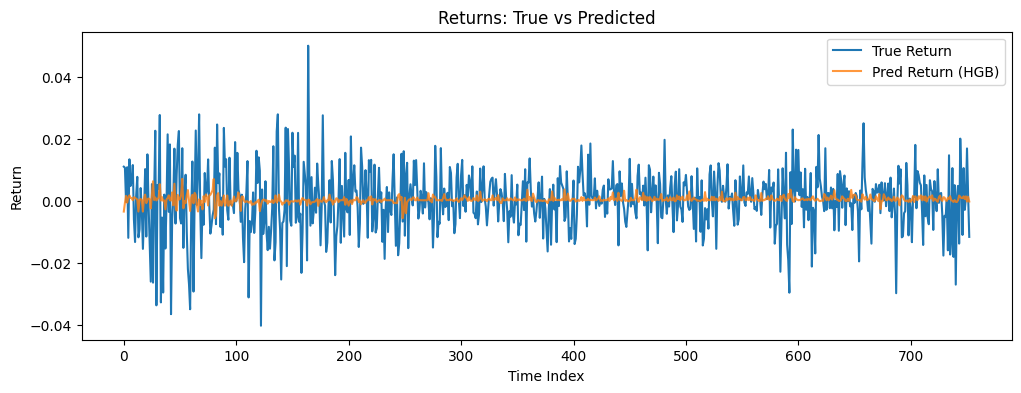

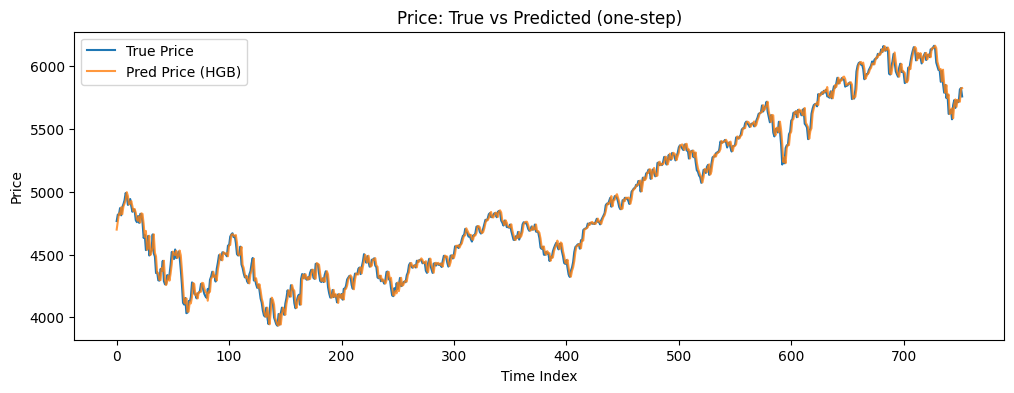

In [12]:
# Returns plot
plt.figure(figsize=(12,4))
plt.plot(y_test.to_numpy(), label="True Return")
plt.plot(pred_ret_hgb, label="Pred Return (HGB)", alpha=0.8)
plt.title("Returns: True vs Predicted")
plt.xlabel("Time Index"); plt.ylabel("Return")
plt.legend()
plt.show()

# Price plot
plt.figure(figsize=(12,4))
plt.plot(P_true, label="True Price")
plt.plot(P_pred_hgb, label="Pred Price (HGB)", alpha=0.8)
plt.title("Price: True vs Predicted (one-step)")
plt.xlabel("Time Index"); plt.ylabel("Price")
plt.legend()
plt.show()

     feature  importance_mean  importance_std
3   d_acc_l1         0.006555        0.002684
2   d_mom_l1         0.003305        0.000861
0   d_ret_l1         0.002925        0.006189
1     d_z_l1         0.002854        0.002751
5  d_sign_l1         0.000794        0.000788
4   abs_z_l1        -0.000434        0.002483


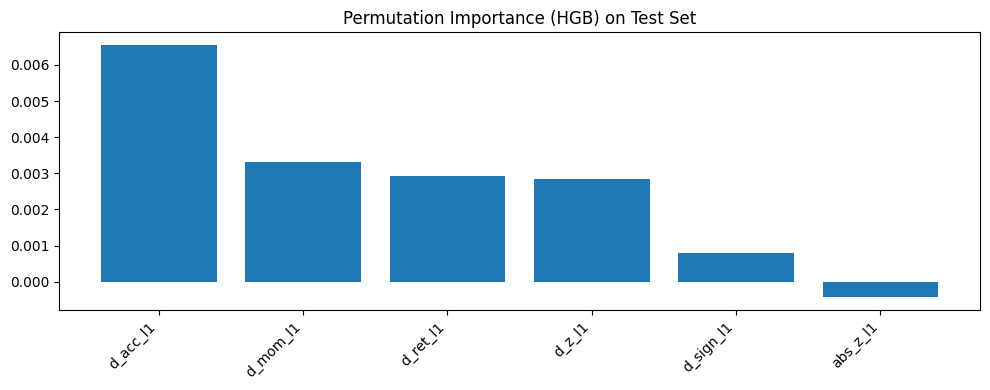

In [13]:
imp = permutation_importance(best_hgb, X_test, y_test, n_repeats=15, random_state=42)

imp_df = pd.DataFrame({
    "feature": X_cols,
    "importance_mean": imp.importances_mean,
    "importance_std": imp.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp_df)

plt.figure(figsize=(10,4))
plt.bar(imp_df["feature"], imp_df["importance_mean"])
plt.xticks(rotation=45, ha="right")
plt.title("Permutation Importance (HGB) on Test Set")
plt.tight_layout()
plt.show()